##Setup

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, AvgPool1D, Dense, Softmax
from tensorflow.keras.datasets import imdb


##Data

In [ ]:
max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [ ]:
#Preparing Train and Test Subet set
from sklearn.model_selection import train_test_split

x_train_sub, _,y_train_sub,_ = train_test_split(x_train, y_train, stratify=y_train, train_size=.08, shuffle = True,)
x_test_sub, _, y_test_sub,_ = train_test_split(x_test, y_test, stratify=y_train, train_size=.004, shuffle = True,)

print('Training set size:',x_train_sub.shape)
print('Test set size',x_test_sub.shape)

Training set size: (2000, 80)
Test set size (100, 80)


##Word Dictionary

In [ ]:
#Word Dictionary 
word_dictionary = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [ ]:
index_to_word_dictionary = dict(zip(word_dictionary.values(),word_dictionary.keys()))

In [ ]:
def index_to_word(index):

  if (index > 0) and (index < len(word_dictionary)):

    return index_to_word_dictionary.get(index)

  return 'not in dictionary'

def show_sentence(x):
  for j in x:
    print(index_to_word(j),' ', end='')
  print()

##Model

In [ ]:
#Builiding Model 
e = Embedding(max_features, 80, input_length=80,mask_zero=True)
l = LSTM(80, dropout=0.2, recurrent_dropout=0.2)
d = Dense(1, activation='sigmoid') 

model = Sequential([e,l,d])
#model.add(Softmax())

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 80)            1600000   
_________________________________________________________________
lstm (LSTM)                  (None, 80)                51520     
_________________________________________________________________
dense (Dense)                (None, 1)                 81        
Total params: 1,651,601
Trainable params: 1,651,601
Non-trainable params: 0
_________________________________________________________________


###Training and Testing

In [ ]:
print('Training...')

model.fit(x_train_sub, y_train_sub,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test_sub, y_test_sub),
          callbacks = [])

Training...
Epoch 1/3
63/63 [==============================] - 27s 426ms/step - loss: 0.6723 - accuracy: 0.5745 - val_loss: 0.5983 - val_accuracy: 0.6300
Epoch 2/3
63/63 [==============================] - 27s 423ms/step - loss: 0.4056 - accuracy: 0.8380 - val_loss: 0.6086 - val_accuracy: 0.8000
Epoch 3/3
63/63 [==============================] - 27s 423ms/step - loss: 0.1498 - accuracy: 0.9500 - val_loss: 0.6718 - val_accuracy: 0.7500


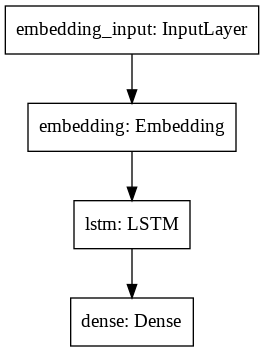

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [ ]:

score, acc = model.evaluate(x_test_sub, y_test_sub,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

4/4 [==============================] - 0s 36ms/step - loss: 0.6718 - accuracy: 0.7500
Test score: 0.6718183755874634
Test accuracy: 0.75


##Creating Attack

In [ ]:
##Create Jacobean function

def jacobian_for(x):
  """
  Calculate jacobian of logits wrt input.
  """
  x = tf.convert_to_tensor(x,dtype=tf.float32)
  x = tf.expand_dims(x,0)

  with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
  
  
    tape.watch(e.variables)

    y = model(x)

  return tf.squeeze(tape.jacobian(y, e.variables, parallel_iterations=100, experimental_use_pfor=False))
  

In [ ]:
def convert_to_label(y):
  if y[0]<=.5:
    y = 0
  else:
    y = 1
  return y


def imdb_attack(f, x, D=np.array(list(word_dictionary.values()),dtype='int64'), max_iter=100):

  """performs attack proposed in Papernot et
al, Crafting Adversarial Input Sequences for Recurrent
Neural Networks."""

  y = f.predict(x)

  y = convert_to_label(y)

  x_ad = x.copy()

  ad_prediction = convert_to_label(f.predict(x_ad))

  jacobian = jacobian_for(np.squeeze(x))

  iteration = 0

  while ad_prediction == y:

    iteration += 1

    if iteration > max_iter:
      break

    #print('\niteration:',iteration)

    i = np.random.randint(0,80,1)[0]

    #print('i:',i)

    #==================TODO==============================
    # 1. Figure out function for w as described in paper
    #
    #====================================================
    j_x = jacobian[i]

    z = tf.argmin(np.sign(D - x_ad[0][i])) #+ 1 #b/c dictionary starts on index 1

    w = np.abs(z - np.sign(j_x[i]))


    #================================================
    #================================================
   
    #=======DELETE WHEN FUNCTION IS FULLY IMPLEMENTED
    if w==None: break 
    #=======DELETE WHEN FUNCTION IS FULLY IMPLEMENTED
    #print('old word:',x_ad[0][i],index_to_word(x_ad[0][i]))

    if not w < max_features:
      continue

    #print('new word:',w,index_to_word(w))

    
    x_ad[0][i]=w

    ad_prediction = convert_to_label(f.predict(x_ad))

  #return adversarial example

  if ad_prediction != y:
    print(' NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN',iteration,'ITERATIONS')

  return x_ad

##Testing Attack

In [ ]:
np.average([7,1,19,77,47,2,9,7,66,71,65,27,88,73,15,15,23,10,38,29,28,4,58,35,1,27,25,2,36,66,12,16,30,88,17,41,72,2,77,15,1,62,12,22,59,40,64,57,29,61,11,11,89,53])

35.407407407407405

In [ ]:
#creting adversarial examples
adversarial_example = np.array([imdb_attack(model,np.expand_dims(i,0)) for i in x_test_sub]).squeeze()

 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 7 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 1 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 19 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 77 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 47 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 2 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 9 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 7 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 66 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 71 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 65 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 27 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 88 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 73 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 15 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 15 ITERATIO

In [ ]:
##Connect to drive to save or restore ad_examples

#from google.colab import drive
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#np.save('drive/My Drive/secure_and_private_ai_project/adversarial_examples.npy',adversarial_example)

In [ ]:
#adversarial_example = np.load('drive/My Drive/secure_and_private_ai_project/adversarial_examples.npy')

###Changes to Sentences

In [ ]:
for i in range(len(adversarial_example)):
  print('Sentence ',i,'Original')
  
  show_sentence(x_test_sub[i])

  print('\nSentence ',i,'Adversarial')

  show_sentence(adversarial_example[i])

  print('===========================================================================================================================================================\n')

Sentence  0 Original
credit  half  film  it  is  worn  over  genre  for  incidental  in  political  mafia  in  while  characters  not  an  that  end  it  cannot  of  self  slow  virginia  some  br  read  been  impressed  since  film  really  from  after  one  cinema  to  plays  is  now  on  then  also  we  enjoy  that  with  very  in  can  when  legs  from  off  ever  not  what  from  after  one  out  bit  up  film  of  shepherd  i  i  seen  mean  funny  very  less  half  scheming  this  of  and  

Sentence  0 Adversarial
credit  half  film  it  is  worn  already  genre  for  incidental  in  political  mafia  in  while  characters  not  an  that  end  it  cannot  of  self  slow  virginia  some  summoned  read  been  to  since  laughable  really  from  after  one  cinema  to  plays  is  now  on  then  also  matter  enjoy  that  with  very  in  can  when  legs  from  off  ever  not  what  from  after  one  out  bit  up  film  of  shepherd  i  i  seen  mean  already  very  less  half  sch

###Results

In [ ]:
#testing model on adversarial examples
print(model.evaluate(x_test_sub,y_test_sub,batch_size=batch_size))
print(model.evaluate(adversarial_example, y_test_sub, batch_size=batch_size)) 

4/4 [==============================] - 0s 38ms/step - loss: 0.7095 - accuracy: 0.8300
[0.7095215320587158, 0.8299999833106995]
4/4 [==============================] - 0s 38ms/step - loss: 0.8906 - accuracy: 0.6600
[0.8905950784683228, 0.6600000262260437]
